In [69]:
import os
import pandas as pd
import numpy as np
import glob

from numpy import mean
from numpy import std

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

%config InlineBackend.figure_formatrmat = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [16]:
data_dir = "../data/Air_Models/"

scenario_index = pd.DataFrame({"filepath": glob.glob(os.path.join(data_dir, "IG_*_*.csv"))})
scenario_index

,filepath
0,../data/Air_Models/IG_500_390.csv
1,../data/Air_Models/IG_520_300.csv
2,../data/Air_Models/IG_530_300.csv
3,../data/Air_Models/IG_600_560.csv
4,../data/Air_Models/IG_600_400.csv
...,...
135,../data/Air_Models/IG_370_300.csv
136,../data/Air_Models/IG_600_550.csv
137,../data/Air_Models/IG_600_430.csv
138,../data/Air_Models/IG_550_340.csv


In [17]:
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=5)

train_index, test_index  = next(cv.split(scenario_index.index))
 
print("TRAIN:", train_index, "TEST:", test_index)
print("TRAIN count:", len(train_index), "TEST count:", len(test_index))

TRAIN: [  0   1   2   3   4   5   6   7   8   9  11  13  14  15  16  17  18  19
  20  22  24  26  27  28  29  30  31  32  33  34  35  36  37  38  39  41
  42  44  45  47  49  51  55  56  57  58  59  61  62  63  64  65  67  68
  69  71  72  73  76  77  78  79  80  81  82  83  84  85  86  87  88  91
  92  93  95  96  97  99 100 101 103 104 105 106 110 112 113 114 115 116
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139] TEST: [ 10  12  21  23  25  40  43  46  48  50  52  53  54  60  66  70  74  75
  89  90  94  98 102 107 108 109 111 117]
TRAIN count: 112 TEST count: 28


In [18]:
def load_data(scenario_index, selected_index, is_recurrent_test_data=False):
    """ Load data from files in scenario_index with indices matching ones in selected_index"""
    
    df_arr = []
    for f in scenario_index.loc[selected_index].filepath:
        Tw = float(f.split("/")[-1].split("_")[1])
        Ti = float(f.split("/")[-1].split("_")[2].replace(".csv", ""))

        f_df = pd.read_csv(f, skiprows=12)
        f_df["Tw"] = Tw
        f_df["Ti"] = Ti
        df_arr.append(f_df)
    
    if is_recurrent_test_data:
        return df_arr
    
    combined_df = pd.concat(df_arr)
    return combined_df

In [62]:
# transform a time series dataset into a supervised learning dataset
# source: https://machinelearningmastery.com/random-forest-for-time-series-forecasting/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    df = pd.DataFrame(data)
    cols = list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        
    # put it all together
    combined_df = pd.concat(cols, axis=1)
    
    # drop rows with NaN values
    if dropnan:
        combined_df.dropna(inplace=True)
        
    return combined_df.values

In [63]:
def get_train_data(is_recurrent=False):
    train_df = load_data(scenario_index, train_index)
    if is_recurrent:
        train = train_df[["Time", "Tw", "Ti", "Tc"]].to_numpy()
        train_shift = pd.DataFrame(series_to_supervised(train))
        # Get rid of last prediction for each set, 
        # because the next datapoint is the first datapoint of the next set
        train_shift.drop(train_shift[train_shift[0] == 21.15].index, inplace = True)
        train_shift = train_shift.to_numpy()
        X_train = train_shift[:, 0:4]
        y_train = train_shift[:, -1]
    else:
        X_train = train_df[["Time", "Tw", "Ti"]].to_numpy()
        y_train = train_df[["Tc"]].to_numpy().reshape(-1,)
    return X_train, y_train

In [67]:
def get_test_data(is_recurrent=False):
    if is_recurrent:
        test_data = load_data(scenario_index, test_index, is_recurrent_test_data=True)
        test_df_list = list()
        for test_df in test_data:
            test = test_df[["Time", "Tw", "Ti", "Tc"]].to_numpy()
            test_shift = series_to_supervised(test)
            test_df_list.append(test_shift)
        X_test = list()
        y_test = list()
        for test_shift in test_df_list:
            X, Y = test_shift[:, 0:-5], test_shift[:, -1]
            X_test.append(X)
            y_test.append(Y)
        X_test = np.array(X_test)
        y_test = np.array(y_test)
    else:
        test_df = load_data(scenario_index, test_index)
        X_test = test_df[["Time", "Tw", "Ti"]].to_numpy()
        y_test = test_df[["Tc"]].to_numpy().reshape(-1,) 
        
    return X_test, y_test

In [72]:
def get_model(model_type="XGBoost", n_estimators=10):
    if model_type == "XGBoost":
        model = XGBRegressor(n_estimators=n_estimators, colsample_bylevel=.75)
    elif model_type == "RandomForest":
        model = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, random_state=30)
    else:
        print("Please choose either XGBoost or RandomForest for model type")
        return None
    return model

In [44]:
def walk_forward_validation(X_test_sample):
    predictions = list()
    Tc = X_test_sample[0][2]
    for time_step in X_test_sample:
        time_step = np.append(time_step,Tc)
        Tc = model.predict(time_step.reshape(1, -1))
        predictions.append(Tc.tolist()[0])
    return predictions

In [71]:
def get_predictions(model, X_test, is_recurrent=False):
    if is_recurrent:
        y_hat = list()
        for X_test_sample in X_test:
            y_hat_sample = walk_forward_validation(X_test_sample)
            y_hat += y_hat_sample
            y_hat.append(y_hat_sample[-1])
        y_hat = np.array(y_hat)
    else:
        y_hat = model.predict(X_test)
    
    return y_hat

In [75]:
X_train, y_train = get_train_data(is_recurrent=True)
X_test, y_test = get_test_data(is_recurrent=True)

model = get_model(model_type="RandomForest")
model.fit(X_train, y_train)

y_hat = get_predictions(model, X_test, is_recurrent=True)

test_df = load_data(scenario_index, test_index)
test_df["Tc_hat"] = y_hat

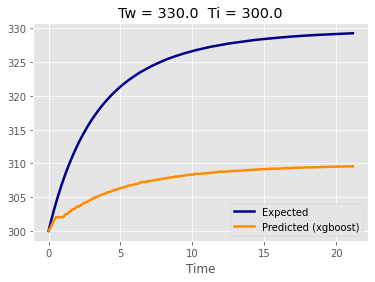

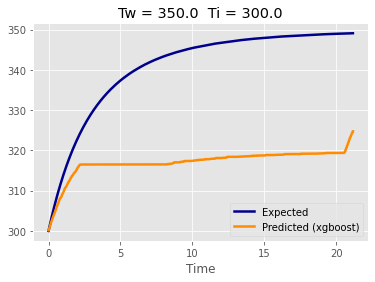

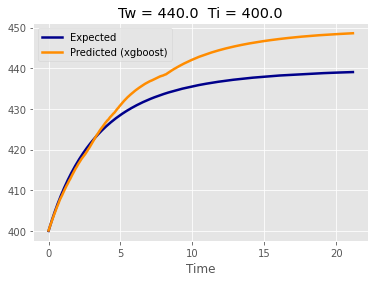

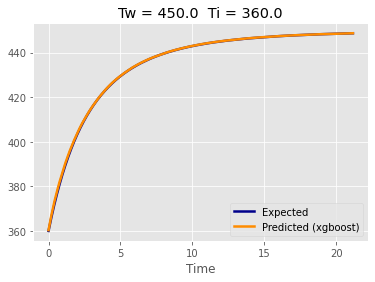

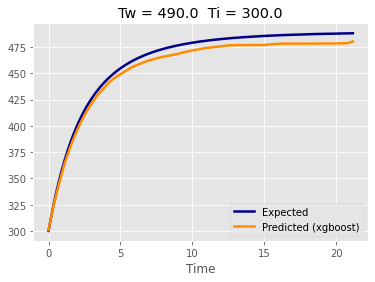

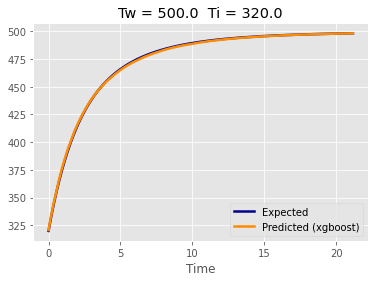

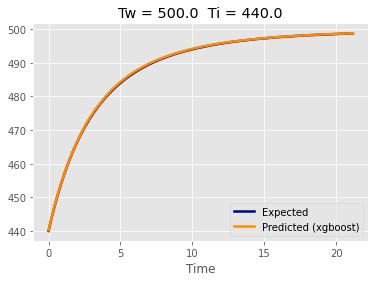

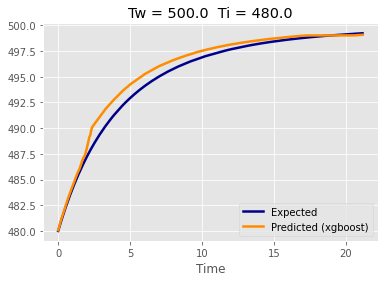

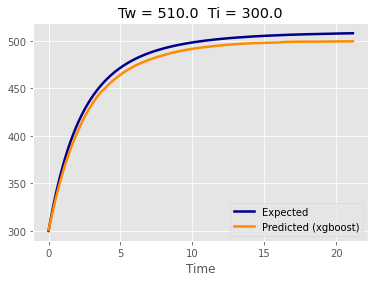

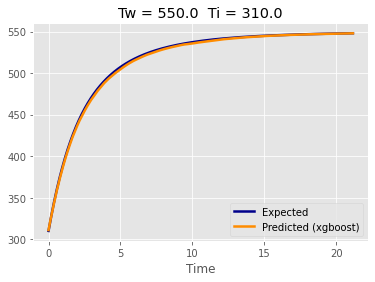

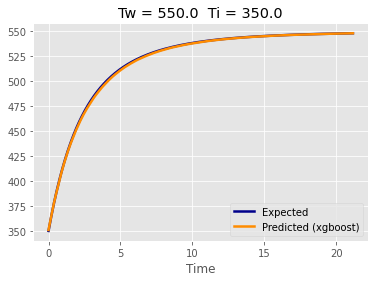

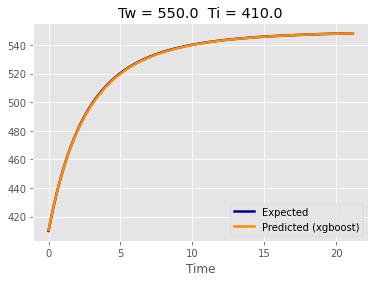

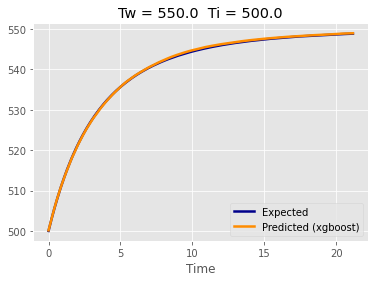

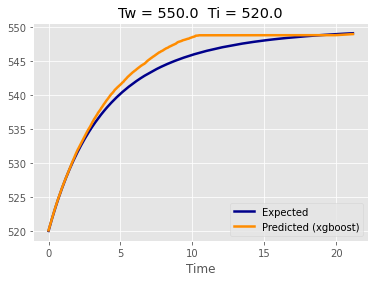

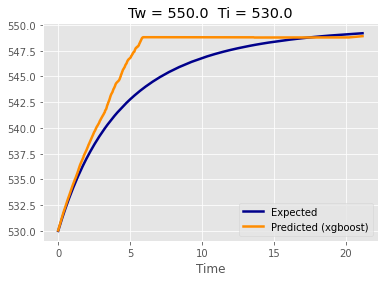

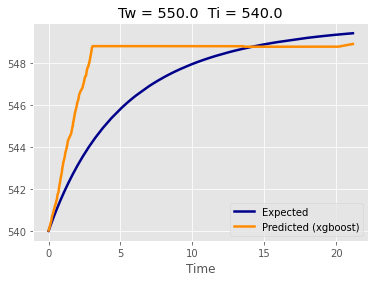

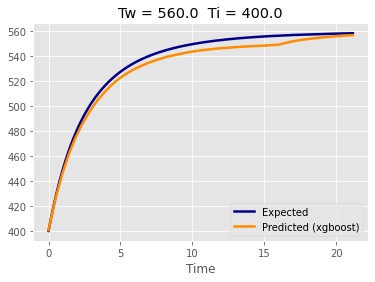

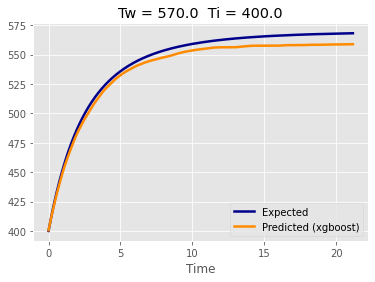

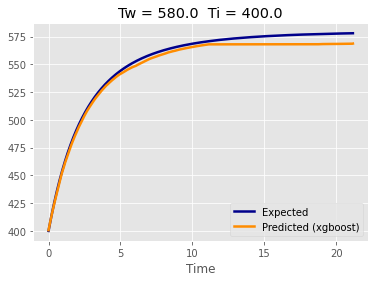

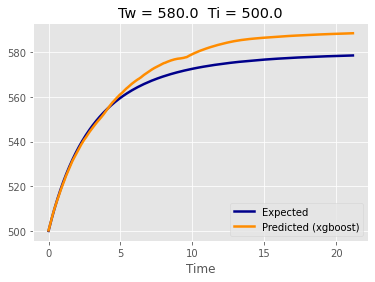

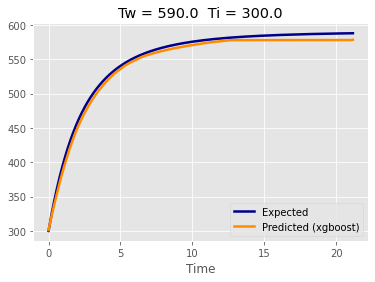

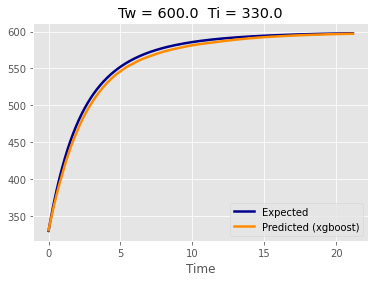

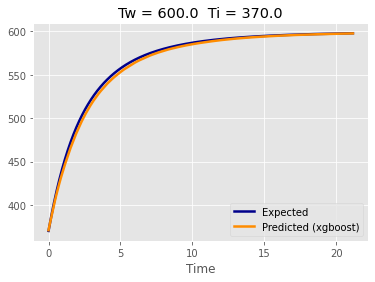

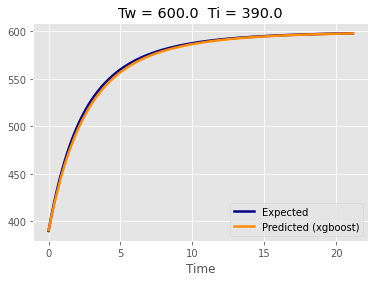

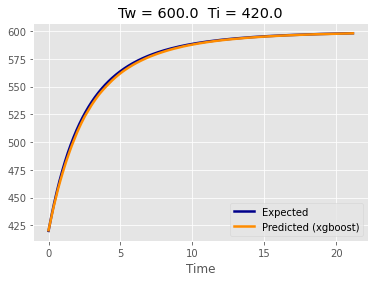

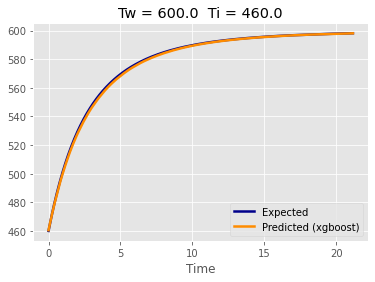

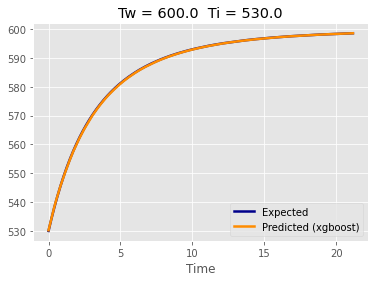

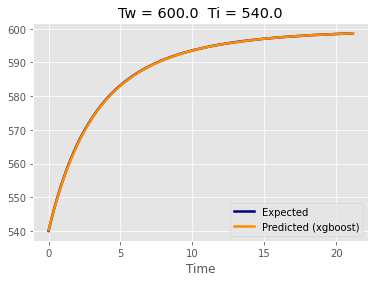

In [76]:
import matplotlib
for idx, grp in test_df.groupby(["Tw", "Ti"]):
    ax = grp.plot(x="Time", y='Tc', c='DarkBlue', linewidth=2.5, label="Expected")
    plot = grp.plot(x="Time", y='Tc_hat', c='DarkOrange', linewidth=2.5, label="Predicted (xgboost)", ax=ax)
    plt.title('Tw = {Tw}  Ti = {Ti}'.format(Tw=idx[0], Ti=idx[1]))
    plt.show()